<h3>Decision Tree</h3>

<hr>

Decision tree is one of the most intuitive machine learning algorithms.

We use decision tree in our life a lot except we dont call it decision tree.

Decision tree is basically a replicate of our decision-making process with a lil twitch of math.

It borrows a lot of concepts from information theory to create tree branches.

It is less black-box compared to other machine learning algorithms.


For information gain, please refer to the following link

https://towardsdatascience.com/gini-index-vs-inFormation-entropy-7a7e4fed3fcb

For tree splitting, please refer to the following link

https://lethalbrains.com/learn-ml-algorithms-by-coding-decision-trees-439ac503c9a4

For tree building, please refer to the following link

https://machinelearningmastery.com/implement-decision-tree-algorithm-scratch-python/

In [1]:
#decision tree has a very similar structure to binary tree
#if you dont know binary tree, i strongly recommend you to read the following link
#  https://runestone.academy/runestone/books/published/pythonds/Trees/toctree.html
#even though this repository is about reinventing the wheel
#reinventing the wheel is the best way to develop a deep understanding of the knowledge
#i quoted myself at the beginning of this repository
#i am not gonna rebuild a tree structure here
#instead I will use network package to create the data structure
#and it is good for our final visualization of the tree structure
#i have reinvented graph structure in my repository graph theory
# https://github.com/je-suis-tm/graph-theory/blob/master/graph.py
#even for reinventing the wheel, I only reinvent once, so networkx it is
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import copy
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

In [2]:
#there two types of impurity here, entropy and information theory
#of course you can use miscalculation error
#i just don’t find it very convincing, thats all
def impurity(data,method):

    output=0.0
    
    for i in set(data):      
                    
        prob=list(data).count(i)/len(data)
        
        if method=='gini':
            output+=prob**2
        
        #entropy
        else:
            output+=prob*(np.log(prob)/np.log(2))
    
    extra=1 if method=='gini' else 0
    
    return extra-output
    

In [3]:
#information gain is function built upon impurity
def information_gain(parent,left,right,method):
    
    leftc=len(left)/len(parent)
    rightc=len(right)/len(parent)
    
    sumc=leftc*impurity(left,method)+rightc*impurity(right,method)
    
    return impurity(parent,method)-sumc 

In [4]:
#when we need to create tree branches (split a node into two children)
#we would love to select a criterion that maximizes information gain
#in human language, we wanna have two chaotic children nodes after the split
#when the child node shows non dominant class within the group
#it has the largest entropy (uncertainty) which maximizes information gain
def node_split(df,x,y,method):
    
    info=0.0
    target=0.0
    
    for i in df[x].tolist():
        
        #values smaller than the threshold go to left child node
        left=df[y].loc[df[x]<i].tolist()
        right=df[y].loc[df[x]>=i].tolist()
        
        temp=information_gain(df[y].tolist(),left,right,method)
            
        if info<temp:
            info=temp
            target=i
    
    #we output both split threshold and its information gain
    return target,info

In [5]:
#this function examines all the potential split threshold
#we can split from the current input factor or use another input factor
#at the end, we only select the criterion that has the largest information gain
def factors_split(df,y,method):
    
    output=pd.DataFrame()
    
    for i in df.columns:
        
        if i!=y:

            target,info=node_split(df,i,y,method)
            output[i]=[target,info]
        
    output=output.T
    output.reset_index(inplace=True)
    output.columns=['colname','target','info']
    
    #sort by information gain in descending order
    output.sort_values(by='info',inplace=True,
                       ascending=False)
    output.reset_index(inplace=True,drop=True)
    
    return output

In [6]:
#like graph theory, data structure plays a bigger role than algorithm
#how to build our tree properly is crucial to our model
#tree building is done recursively
#if you are not confident with your knowledge in recursion
# https://github.com/je-suis-tm/recursion-and-dynamic-programming
def build_tree(df,parentname,tree,xcol,ycol,
               max_tree_depth=50,min_node_num=2,
               method='gini'):

    temp=df.loc[tree.nodes[parentname]['data']]
    
    #this determines how to split to have the largest information gain
    guide=factors_split(temp,ycol,method)
    
    target=guide['target'][0]
    colname=guide['colname'][0]
    
    left=temp.loc[temp[colname]<target].index.tolist()
    right=temp.loc[temp[colname]>=target].index.tolist()
    
    #here are the conditions to build children nodes
    
    #we need to preset a maximum tree depth
    #the deeper the tree is, the more likely it will be overfitted
    #one of the biggest flaws of decision tree is overfit
    #we can apply pruning to clean up the tree after we get the model
    #when we reach the maximum tree depth
    #we call it an end to splitting
    #we take the majority within the group as classification
    if len(parentname)>=max_tree_depth: 
        ind=tree.nodes[parentname]['data']
        nx.set_node_attributes(tree,
                               {parentname:
                                {'label':max(df[ycol].loc[ind].tolist(),
                                             key=df[ycol].loc[ind].tolist().count)}})
        
        return

    #there could be a case where the biggest information gain leaves all elements to one child node
    #the other child node has nothing at all
    #we should immediately stop splitting and pick the majority as the classification
    if not left or not right:

        ind=tree.nodes[parentname]['data']
        nx.set_node_attributes(tree,{parentname:
                                     {'label':max(df[ycol].loc[ind].tolist(),
                                                  key=df[ycol].loc[ind].tolist().count)}})
        
        return
    
    #if the data inside the child node has homogenous classification
    #there is no need for further splitting
    #but we wont return the function here cuz this is only the case for left child node
    if len(df[ycol].loc[left].unique())==1:
        
        #when we create a left child node, we just add L to its node name
        #we can track the depth of current node easily by this naming rule
        tree.add_node(f'{parentname}L',data=left,
                      target=target,colname=colname,
                      label=df[ycol].loc[left].iloc[0]
                     )

        tree.add_edge(f'{parentname}', f'{parentname}L')


    else:
        
        #there is another preset parameter, minimum data inside the node
        #if we have too few samples inside the node
        #our split becomes meaningless
        #if we have enough samples inside the node
        #we continue splitting and call our function recursively
        if len(left)>min_node_num:
            tree.add_node(f'{parentname}L',data=left,
                          target=target,colname=colname
                         )

            tree.add_edge(f'{parentname}', f'{parentname}L')
            
            build_tree(df,f'{parentname}L',tree,
                       xcol,ycol,method=method)

        else:
            tree.add_node(f'{parentname}L',data=left,
                          target=target,colname=colname,
                          label=max(df[ycol].loc[left].tolist(),
                                    key=df[ycol].loc[left].tolist().count)
                         )

            tree.add_edge(f'{parentname}', f'{parentname}L')


    #the right child node has the same case as the left one
    if len(df[ycol].loc[right].unique())==1:
        tree.add_node(f'{parentname}R',data=right,
                      target=target,colname=colname,
                      label=df[ycol].loc[right].iloc[0]
                     )

        tree.add_edge(f'{parentname}', f'{parentname}R')

    else:

        if len(right)>min_node_num:
            tree.add_node(f'{parentname}R',data=right,
                          target=target,colname=colname
                         )
            tree.add_edge(f'{parentname}', f'{parentname}R')
            
            build_tree(df,f'{parentname}R',tree,
                       xcol,ycol,method=method)

        else:
            tree.add_node(f'{parentname}R',data=left,
                          target=target,colname=colname,
                          label=max(df[ycol].loc[left].tolist(),
                                    key=df[ycol].loc[left].tolist().count)
                         )

            tree.add_edge(f'{parentname}', f'{parentname}R')

In [7]:
#once we have our tree structure built, prediction is simple
#it is kinda like traversal algorithm in graph theory
#it travels down the tree structure like depth first search
# https://github.com/je-suis-tm/graph-theory/blob/master/BFS%20DFS%20on%20DCG.ipynb
#the function itself is recursive as well
#but when we reach the end of the tree, we do not go one level up
#we get the label attribute of the node and exit
def predict(tree,nodename,data,ind):

    colname=tree.nodes[nodename]['colname']
    target=tree.nodes[nodename]['target']
    edges=[i[1] for i in tree.edges(nodename)]
    
    if not edges:
        forecast=tree.nodes[nodename]['label']
        return forecast
    
    if data[colname].iloc[ind]<target:
        nodename=edges[0]
    else:
        nodename=edges[1]
        
    forecast=predict(tree,nodename,data,ind)
    
    return forecast

In [8]:
#this is a self-made function to create coordinates for a perfect binary tree
#graph visualization in networkx is problematic
#random positions do not fit for a perfect binary tree
#the function borrows an idea from how to plot a pascal triangle
# https://github.com/je-suis-tm/recursion-and-dynamic-programming/blob/master/pascal%20triangle%20better%20structured.py
#though no recursion is implemented

#xwid refers to the horizontal distance between sibling nodes
#ywid refers to the vertical distance between parent node and children nodes
def binary_tree_pos(tree,xwid=5,ywid=-7):    
    
    #this is the depth of the tree
    #basically finding the maximum length of node names
    rownum=max([len(i) for i in tree.nodes])

    lastrow=[i*xwid for i in range(2**(rownum-1))]

    xmat=[lastrow]
    
    #we start from the deepest level to calculate coordinates for each node
    for i in range(rownum-1,0,-1):
        row=[]
        for j in range(1,len(xmat[-1]),2):
            
            #since we assume this is a perfect binary tree
            #the parent node should be located right between two children nodes
            row.append(np.mean([xmat[-1][j],xmat[-1][j-1]]))
        xmat.append(row)

    ymat=[]
    
    #get the correct order
    xmat=xmat[::-1]
    
    #y coordinate simply depends on the depth of a node
    ymat=[[i*ywid for j in xmat[i]] for i in range(len(xmat))]
    
    root='0'
    nodes=[root]
    
    #using our naming rule to get a whole set of node names
    for i in range(1,rownum):
        row=[]
        for j in nodes[-1]:
            row.append(j+'L')
            row.append(j+'R')

        nodes.append(row)
    
    #map coordinates into the specific node
    #even though decision tree is no perfect binary tree
    #some of left/right do not exist
    #as we dont create edges from parent node to non-existent child
    #these non-existent nodes wont appear in visualization
    pos={}
    for row in range(len(nodes)):
        for column in range(len(nodes[row])):
            pos[nodes[row][column]]=(xmat[row][column],
                                     ymat[row][column])
            
    return pos

In [9]:
#concatenate all the functions
def decision_tree(train,test,xcol,ycol,method='gini'):   
    
    #decision tree is a directed graph structure
    #we can only go down but not up
    tree=nx.DiGraph()

    guide=factors_split(train,ycol,method)
    target=guide['target'][0]
    colname=guide['colname'][0]
    
    #the root node has to be added outside of build_tree function
    tree.add_node('0',data=train.index.tolist(),
                 target=target,colname=colname)

    parentname='0'

    build_tree(train,parentname,tree,
               xcol,ycol,method=method)
    
    #visualization using networkx
    ax=plt.figure(dpi=500)
    nx.draw(tree,with_labels=True,
            node_size=100,pos=binary_tree_pos(tree),
            font_size=5)
    
    forecast=[]    
    for i in train.index.tolist():

        forecast.append(predict(tree,'0',train,i))

    train['projection']=forecast
    
    forecast=[]
    for i in test.index.tolist():

        forecast.append(predict(tree,'0',test,i))

    test['projection']=forecast
    
    print('\ntrain accuracy: %s'%(len(train[train['y']==train['projection']])/len(train)))
    print('\ntest accuracy: %s'%(len(test[test['y']==test['projection']])/len(test)))


In [10]:
#official sklearn decision tree
def skl_decision_tree(train,test,xcol,ycol):

    clf=DecisionTreeClassifier().fit(train[xcol],train[ycol])
    print('\ntrain accuracy: %s'%(clf.score(train[xcol],train[ycol])))
    print('\ntest accuracy: %s'%(clf.score(test[xcol],test[ycol])))

In [11]:
xcol=['x0','x1','x2','x3']
ycol='y'

In [12]:
#using the classic iris data
iris=load_iris()

df=pd.DataFrame(iris.data,columns=xcol)

#in decision tree, each input factor has to be float/int
#sklearn has already done that for us
#but if you are using the dataset inside the repository
#you can use np.unique to convert categorical data to int
df[ycol]=iris.target

In [13]:
x_train,x_test,y_train,y_test=train_test_split(df[xcol],df[ycol])
    
train=pd.concat([x_train,y_train],axis=1)
train.reset_index(inplace=True,drop=True)
    
test=pd.concat([x_test,y_test],axis=1)
test.reset_index(inplace=True,drop=True)


train accuracy: 0.96

test accuracy: 0.96


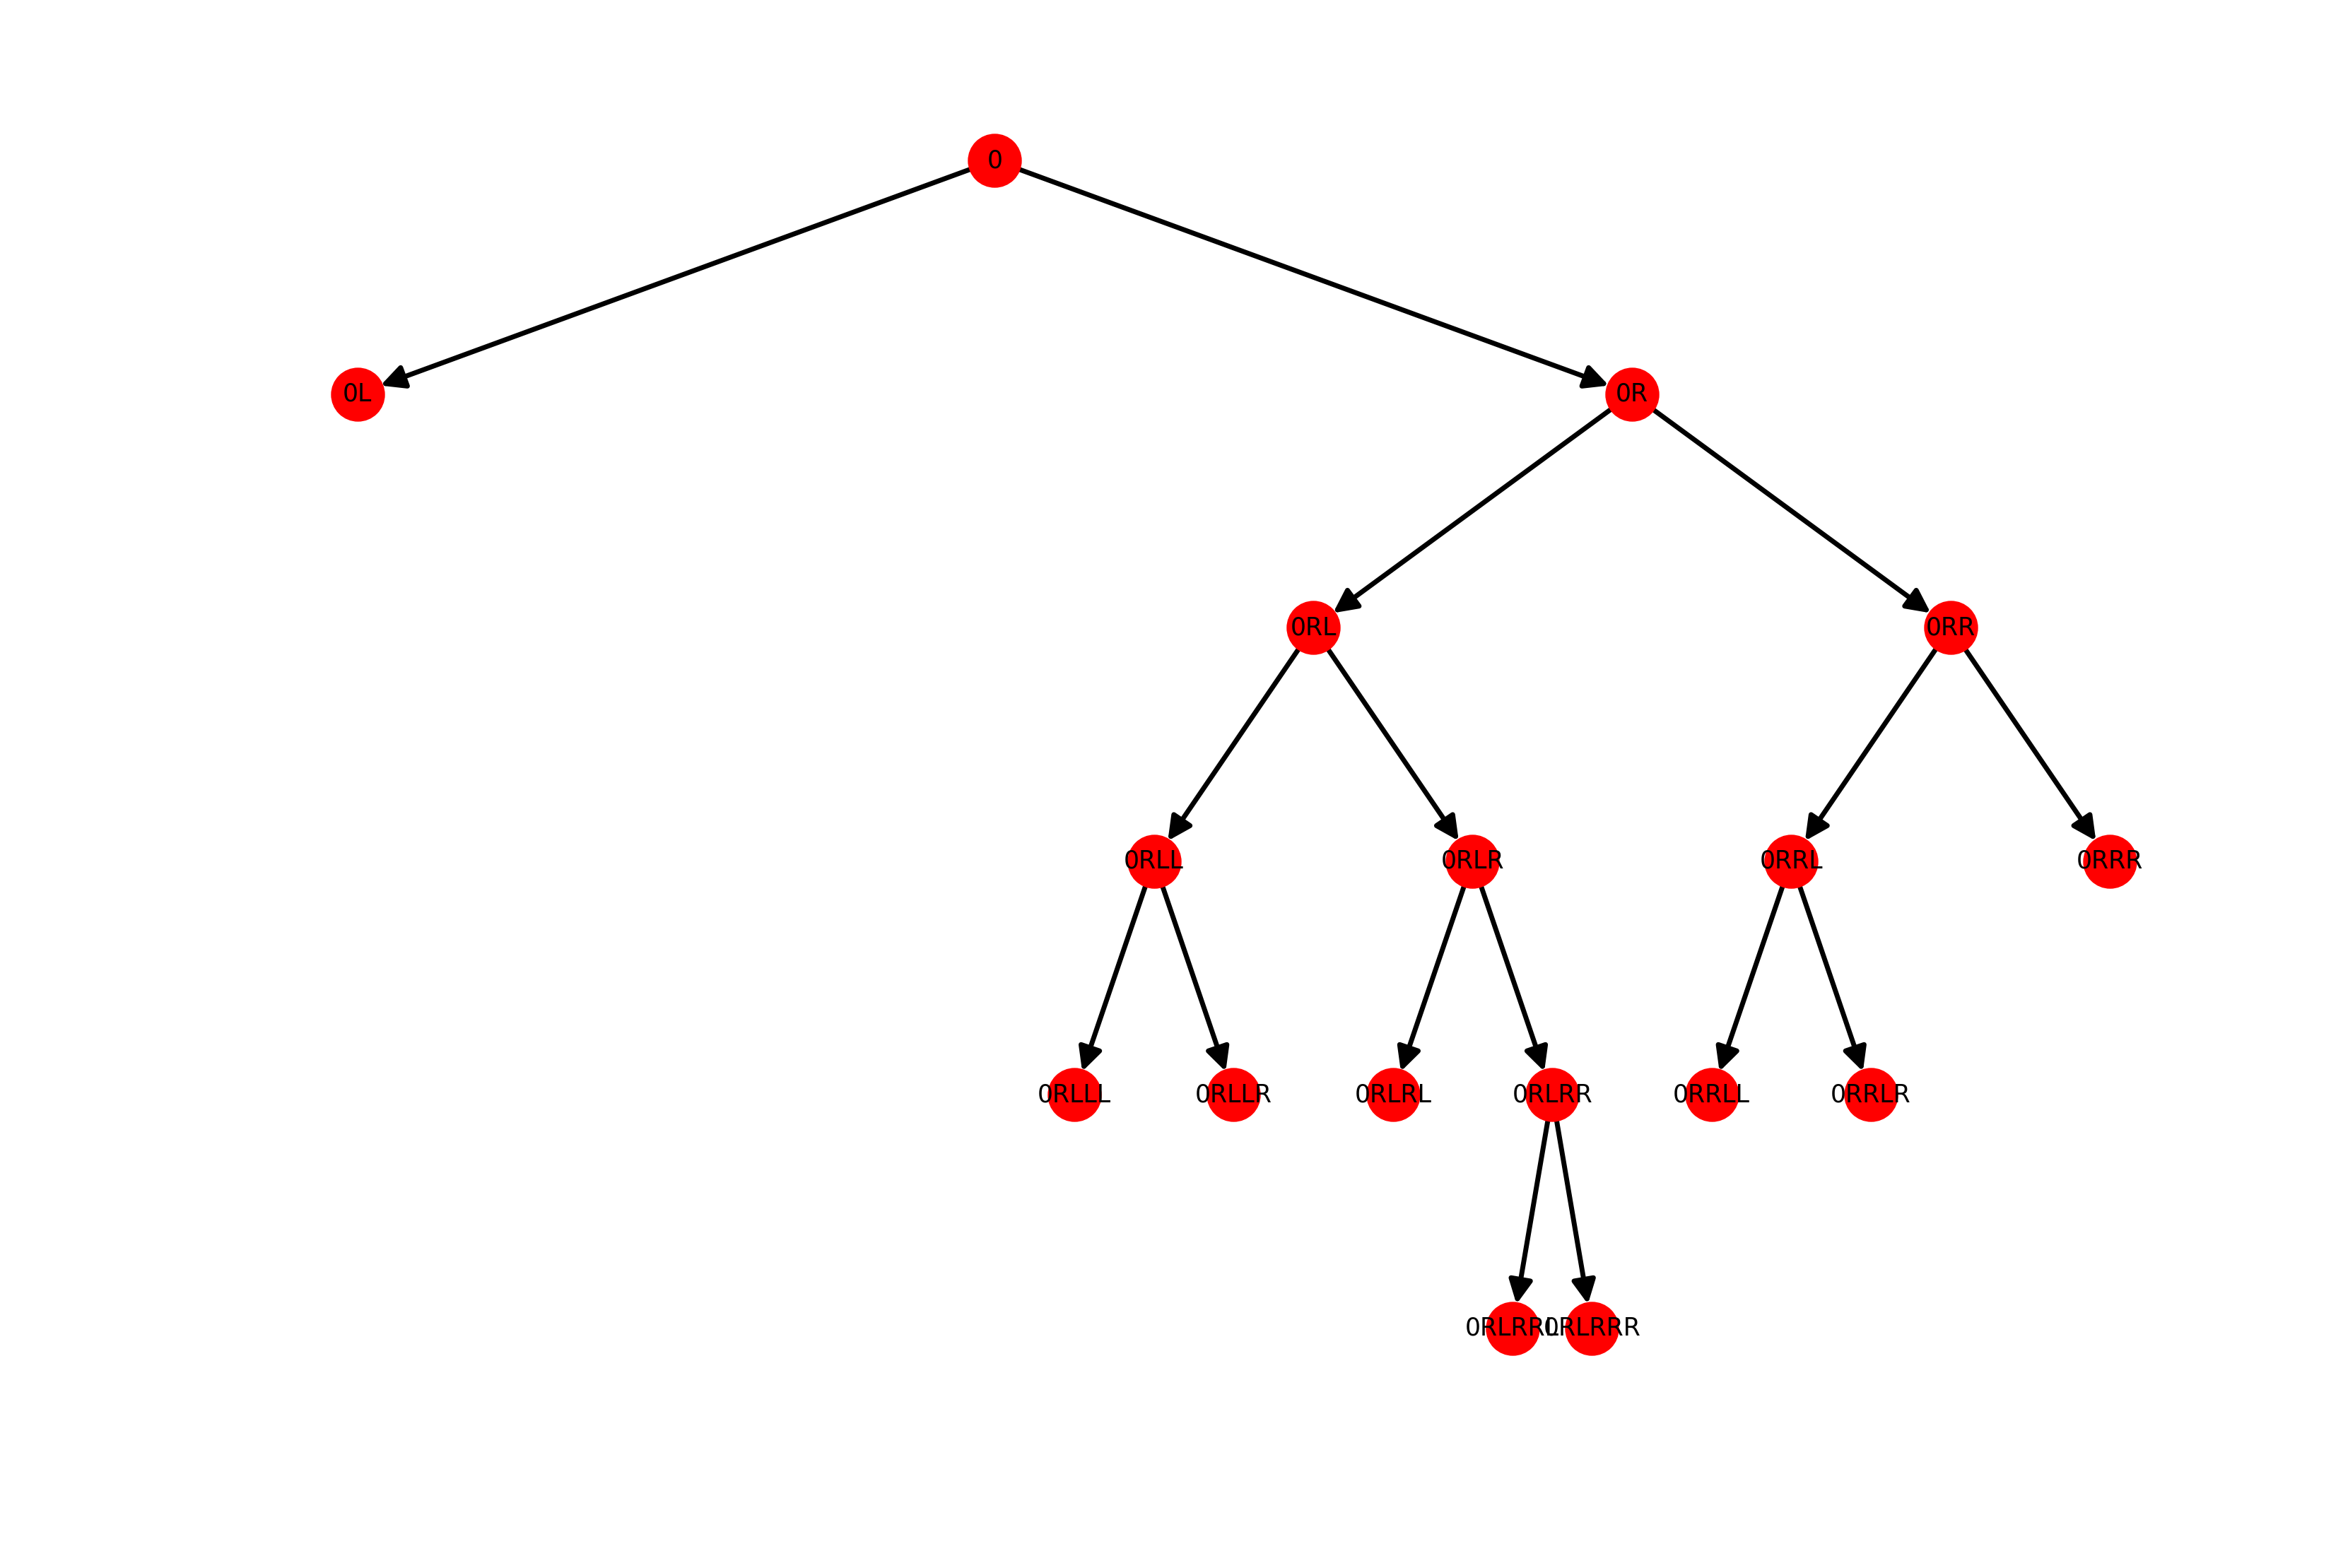

In [14]:
#homemade decision tree
#in-sample data
decision_tree(df,df,xcol,ycol)


train accuracy: 0.9464285714285714

test accuracy: 1.0


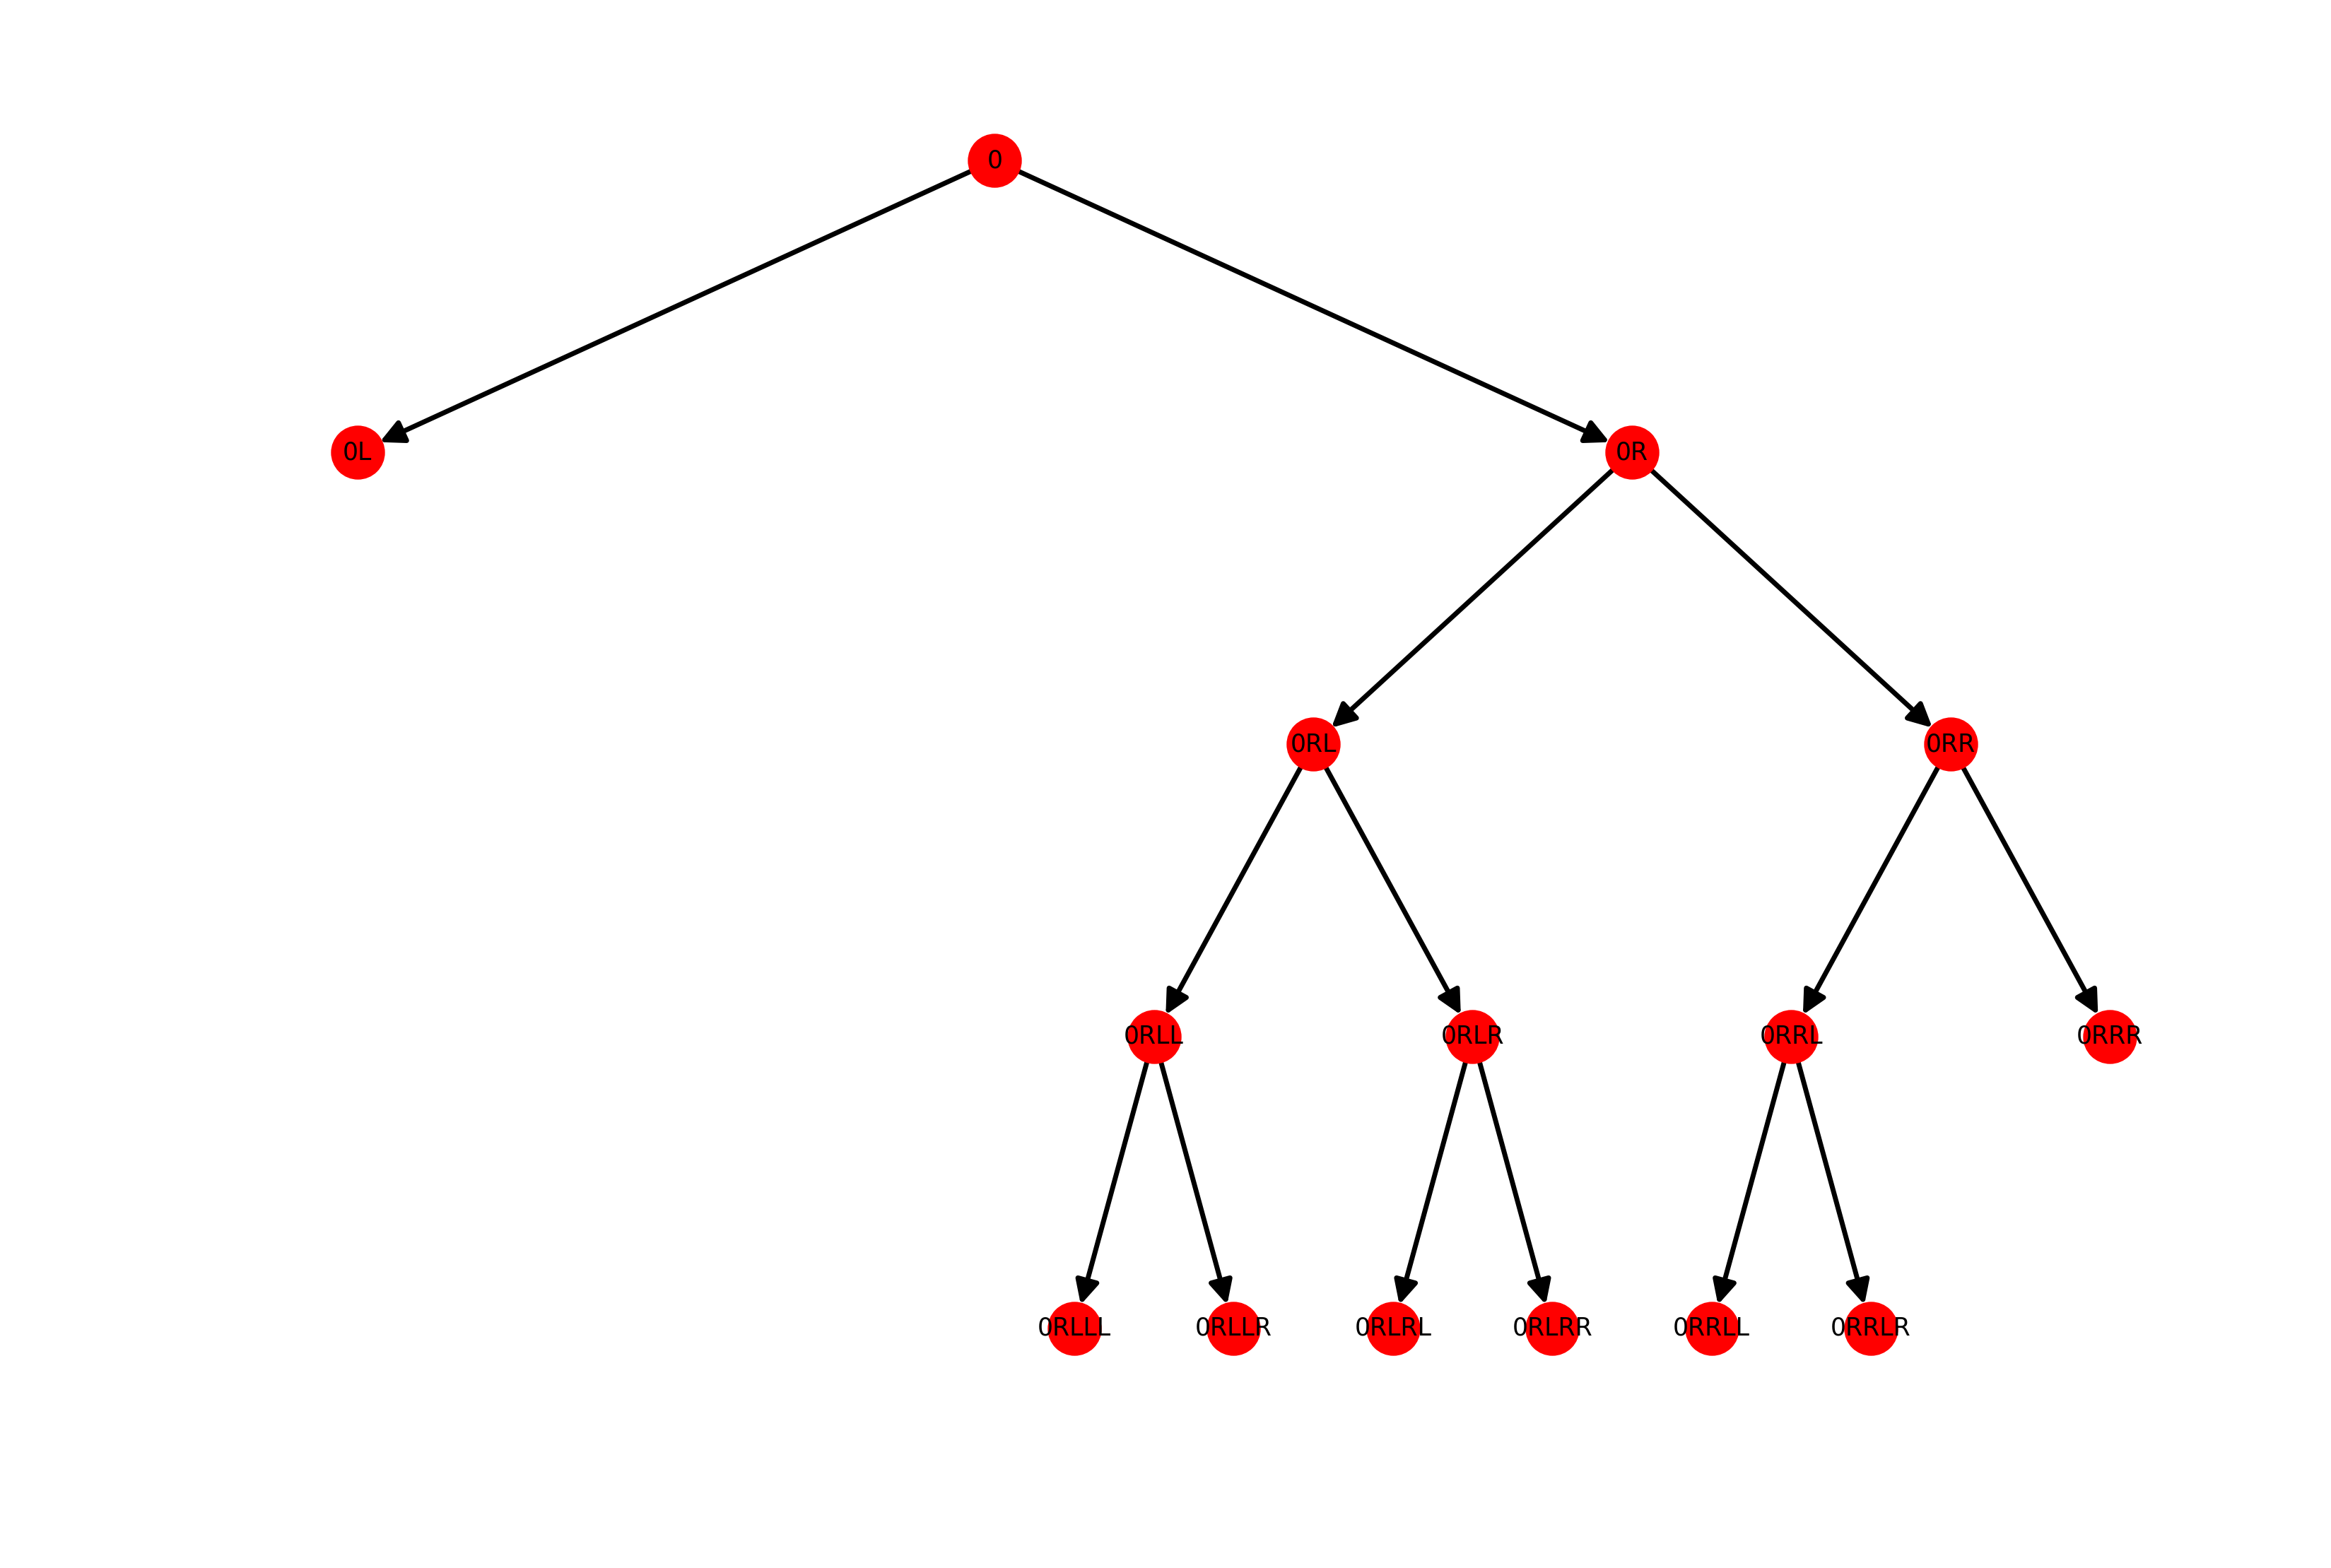

In [15]:
#homemade decision tree
#out-of-sample data (cross validation)
decision_tree(train,test,xcol,ycol)

In [16]:
#sklearn official package
#in-sample data
skl_decision_tree(df,df,xcol,ycol)


train accuracy: 1.0

test accuracy: 1.0


In [17]:
#sklearn official package
#out-of-sample data (cross validation)
skl_decision_tree(train,test,xcol,ycol)


train accuracy: 1.0

test accuracy: 0.9736842105263158


In [18]:
#for some bizarre reason
#homemade decision tree beats sklearn in cross validation
#however, sklearn's performance is more stable and consistent
#homemade can be as low as 60% at accuracy in cross validation